In [38]:
# Cài thư viện cần thiết
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# 1. Đọc dữ liệu
train_df = pd.read_csv("/content/train.csv", parse_dates=["date"])
valid_df = pd.read_csv("/content/validation.csv", parse_dates=["date"])
test_df = pd.read_csv("/content/test.csv", parse_dates=["date"])

print("Train:", train_df.shape)
print("Valid:", valid_df.shape)
print("Test:", test_df.shape)

Train: (37620, 15)
Valid: (5374, 15)
Test: (10749, 15)


In [41]:
# 2. Chuẩn bị dữ liệu
ffeatures = ['tickets_sold', 'tickets_out', 'show_time', 'occu_perc',
            'ticket_price', 'ticket_use', 'capacity', 'month', 'quarter', 'day', 'year']
target = 'total_sales'

X_train = train_df[features].values
y_train = train_df[target].values

X_valid = valid_df[features].values
y_valid = valid_df[target].values

X_test = test_df[features].values
y_test = test_df[target].values

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

X_valid = scaler_X.transform(X_valid)
y_valid_scaled = scaler_y.transform(y_valid.reshape(-1, 1)).flatten()

X_test = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

In [51]:
#3 Mô hình Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_scaled)



RandomForestRegressor(random_state=42)

In [52]:
#4 Dự đoán trên tập validation và test
val_preds_scaled = rf_model.predict(X_valid)
test_preds_scaled = rf_model.predict(X_test)

val_preds = scaler_y.inverse_transform(val_preds_scaled.reshape(-1, 1)).flatten()
test_preds = scaler_y.inverse_transform(test_preds_scaled.reshape(-1, 1)).flatten()
y_valid_orig = scaler_y.inverse_transform(y_valid_scaled.reshape(-1, 1)).flatten()
y_test_orig = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()


In [53]:
#5 Đánh giá
val_rmse = np.sqrt(mean_squared_error(y_valid_orig, val_preds))
val_r2 = r2_score(y_valid_orig, val_preds)
test_rmse = np.sqrt(mean_squared_error(y_test_orig, test_preds))
test_r2 = r2_score(y_test_orig, test_preds)

print(f'Validation RMSE: {val_rmse:.2f}, R²: {val_r2:.4f}')
print(f'Test RMSE: {test_rmse:.2f}, R²: {test_r2:.4f}')

Validation RMSE: 2386027.28, R²: 0.9954
Test RMSE: 1022711.46, R²: 0.9989


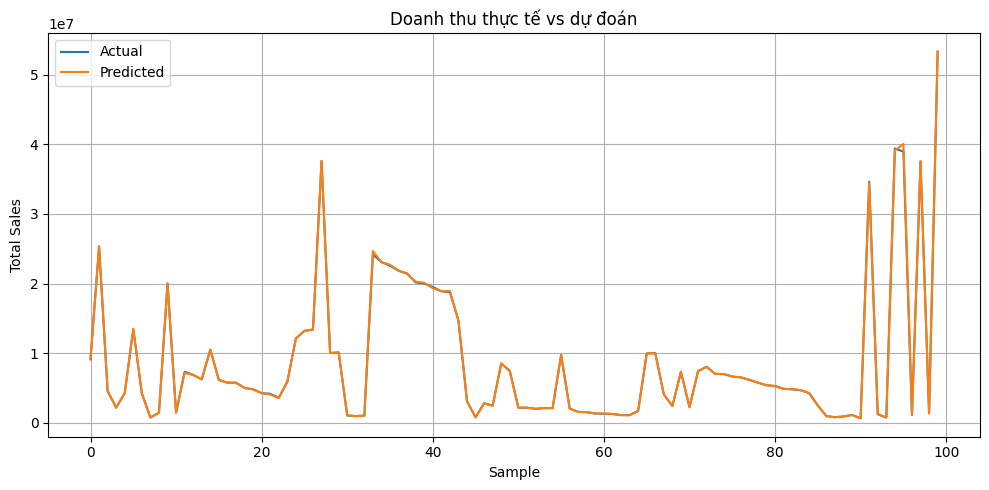

In [54]:
#6 Vẽ biểu đồ Actual vs Predicted
plt.figure(figsize=(10, 5))
plt.plot(y_test_orig[:100], label='Actual')
plt.plot(test_preds[:100], label='Predicted')
plt.legend()
plt.title('Doanh thu thực tế vs dự đoán')
plt.xlabel('Sample')
plt.ylabel('Total Sales')
plt.grid(True)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


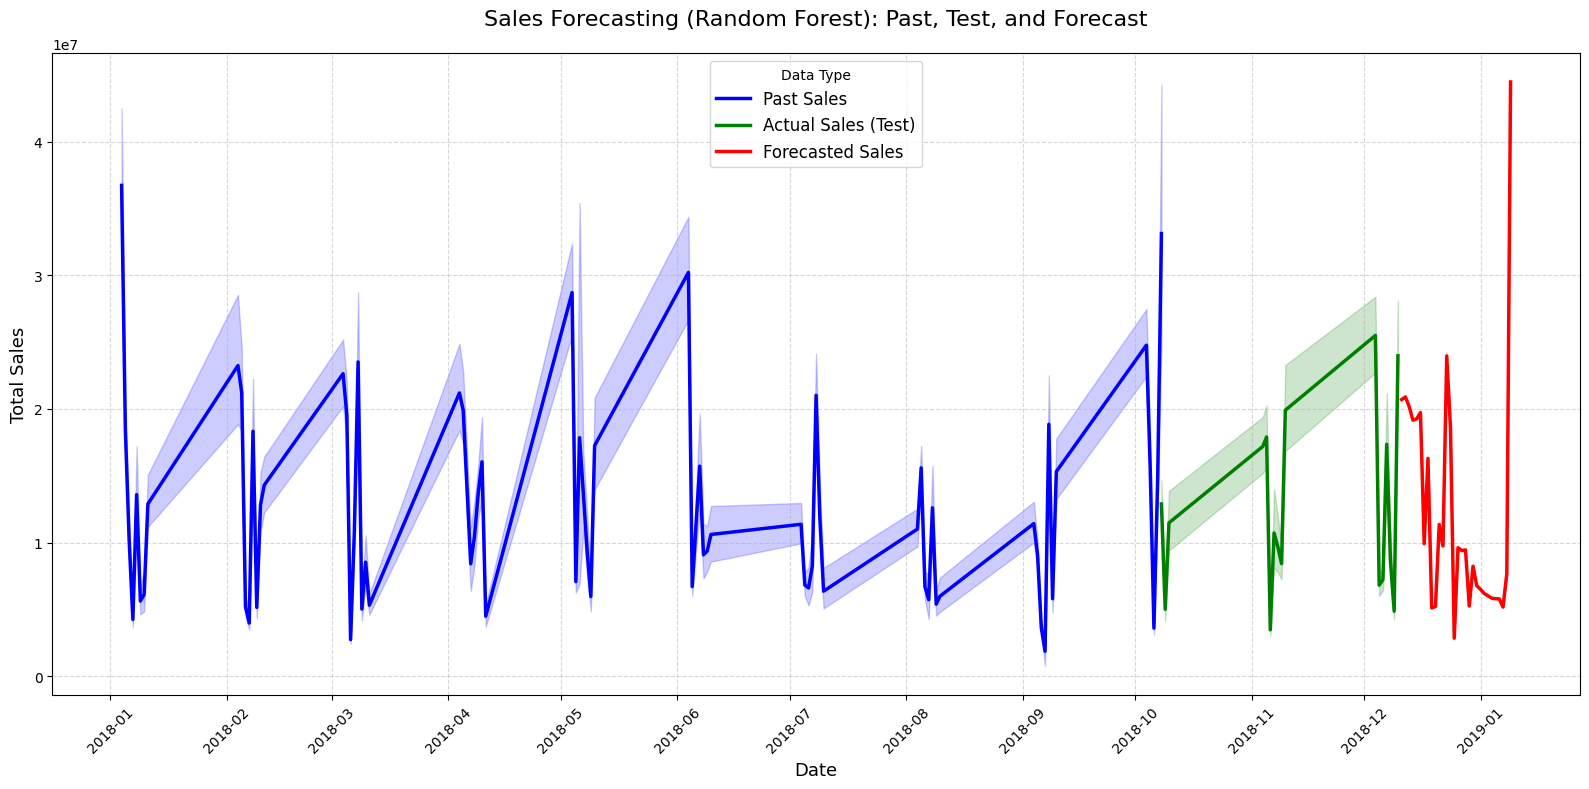

In [55]:
# 7. Dự đoán 30 ngày tiếp theo
last_date = test_df['date'].iloc[-1]
future_dates = pd.date_range(start=last_date + timedelta(days=1), periods=30)

future_X_raw = test_df[features].iloc[-30:].copy()
future_X_scaled = scaler_X.transform(future_X_raw)

future_preds_scaled = rf_model.predict(future_X_scaled)
future_sales = scaler_y.inverse_transform(future_preds_scaled.reshape(-1, 1)).flatten()

future_df = pd.DataFrame({
    'date': future_dates,
    'total_sales': future_sales,
    'type': 'Forecasted Sales'
})

# 8. Visualization tổng thể
train_df['type'] = 'Past Sales'
valid_df['type'] = 'Past Sales'
test_df['type'] = 'Actual Sales (Test)'

combined_df = pd.concat([
    train_df[['date', 'total_sales', 'type']],
    valid_df[['date', 'total_sales', 'type']],
    test_df[['date', 'total_sales', 'type']],
    future_df
], ignore_index=True)

plt.figure(figsize=(16, 8))
sns.lineplot(
    data=combined_df,
    x='date',
    y='total_sales',
    hue='type',
    style='type',
    dashes=False,
    palette={
        'Past Sales': 'blue',
        'Actual Sales (Test)': 'green',
        'Forecasted Sales': 'red'
    },
    linewidth=2.5
)

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.xlabel('Date', fontsize=13)
plt.ylabel('Total Sales', fontsize=13)
plt.title('Sales Forecasting (Random Forest): Past, Test, and Forecast', fontsize=16, pad=20)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Data Type', fontsize=12)
plt.tight_layout()
plt.show()